In [63]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [64]:
# Read data
data = pd.read_csv('../data/raw/clinical_dataset.csv', sep=';').drop(columns=['weight_loss',
                                           'exhaustion_score',
                                           'gait_speed_slower',
                                           'grip_strength_abnormal',
                                           'low_physical_activity'])



In [65]:
# Remove outliers
filled_data = data
for columns in data: 
    if (data[columns].dtype == object):
        data[columns].replace('Test not adequate', np.nan, inplace=True)
        data[columns].replace('test non realizable', np.nan, inplace=True)
    elif (data[columns].dtype == np.float64 or data[columns].dtype == np.int64):
        data[columns].replace(999, np.nan, inplace=True)


# Remove null values
# TODO: Remove entries of features with missing values
# TODO: Remove features with many missing values 
# Find rows where there are mon than 1 null value


for column in data:
    # Rplace nan values with the median of each column
    if data[column].dtype != object and data[column].dtype != bool:
        data[column].fillna(data[column].median(), inplace=True)

    # Replace categorical values with the most used column value 
    elif (data[column].dtype != np.float64 and data[column].dtype != np.int64):
         data[column].fillna(data[column].value_counts().index[0], inplace=True)

# Order categorical data
ordered_categories = {
    'fried': ['Non frail', 'Pre-frail', 'Frail'],
    'gender': ['F', 'M'],
    'gait_optional_binary': [True, False],
    'ortho_hypotension': ['No', 'Yes'],
    'vision': ['Sees well', 'Sees moderately','Sees poorly'  ],
    'audition': ['Hears well', 'Hears moderately', 'Hears poorly' ],
    'weight_loss': ['No', 'Yes'],
    'balance_single': ['>5 sec', '<5 sec'],
    'gait_speed_slower': ['No', 'Yes'],
    'grip_strength_abnormal': ['No', 'Yes'],
    'low_physical_activity': ['No', 'Yes'],
    'memory_complain': ['No', 'Yes'],
    'sleep': ['No sleep problem', 'Occasional sleep problem', 'Permanent sleep problem'],
    'living_alone': ['No', 'Yes'],
    'leisure_club': ['Yes', 'No'],
    'house_suitable_participant': ['Yes', 'No'],
    'house_suitable_professional': ['Yes', 'No'],
    'health_rate': [  '5 - Excellent', '4 - Good', '3 - Medium', '2 - Bad', '1 - Very bad'],
    'health_rate_comparison': [ '5 - A lot better', '4 - A little better', '3 - About the same', '2 - A little worse',
  '1 - A lot worse'],
    'activity_regular': ['> 5 h per week', '> 2 h and < 5 h per week', '< 2 h per week',  'No'],
    'smoking': ['Never smoked', 'Past smoker (stopped at least 6 months)', 'Current smoker']    
}
# encode data
encoder = LabelEncoder()

for column in data:
    if data[column].dtype == np.object or data[column].dtype == np.bool:
        encoder.fit(data[column])
        encoder.classes_ = ordered_categories[column]
        data[column] = encoder.transform(data[column]) 
        
data.to_csv('../data/preprocessed/clinical_dataset_notebook.csv', sep=';')


In [66]:
# Split dataset to train and test 
data_shape = data.shape[0]
splitter = int(np.ceil(0.8*data_shape))
train_data = data.iloc[:splitter]
test_data = data.iloc[splitter:]

In [67]:
# Model Decision trees
tree_classifier = tree.DecisionTreeClassifier()
X = train_data.drop(['fried','part_id'] ,axis=1)
tree_classifier.fit(X, train_data['fried'])


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [68]:
# Predict
test_without_id = test_data.drop(['fried','part_id'], axis=1)
y_predict = tree_classifier.predict(test_without_id)

# Evaluate results
results = {'id': test_data['part_id'],
                        'Actual': test_data['fried'],
                        'predicted': y_predict}

results = pd.DataFrame({'accurancy': [confusion_matrix(results['Actual'],results['predicted'], normalize='all')]})

# Save results
results.to_csv('../data/results/decision_trees_classification.csv', sep=';', index=False)

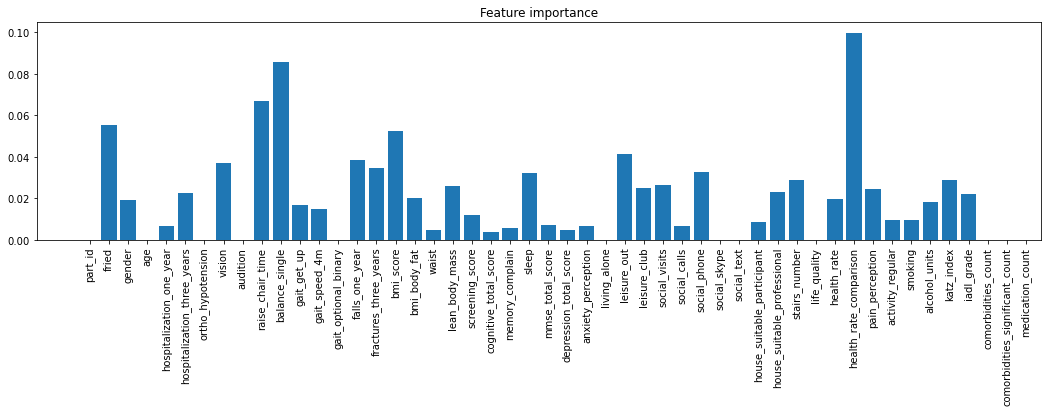

In [69]:
train_columns = list(X.columns)
# train_columns.remove("part_id")
fig, ax = plt.subplots( figsize=(18,4))
ax.bar(range(len(train_columns)),tree_classifier.feature_importances_ )
plt.xticks(range(len(train_data.columns)),train_data.columns,rotation=90)
ax.set_title("Feature importance")
plt.show()